In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GroupShuffleSplit, cross_validate, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../../data/answerList_data.csv')
df['correctness'] = (((df['GroundTruth'] == 0.0) & (df['Answer.option'] == 'NO')) | ((df['GroundTruth'] == 1.0) & (df['Answer.option'] == 'YES'))).astype(int)

df

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,Ground_Truth,TP,TN,FN,...,Worker.ID,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness
0,261,HIT01_8,0,90.984,4,2,0.0,0,1,0,...,832cg-7G1i-462:73eI-8E-2g-985,5,Undergraduate_Student,7.0,21,Male,High School,United States,Java; C++; C#,1
1,262,HIT01_8,0,133.711,5,1,0.0,0,1,0,...,98ce7A-4i-507,4,Undergraduate_Student,10.0,25,Female,High School;University;Web,United States,c#,1
2,263,HIT01_8,0,77.696,5,2,0.0,0,1,0,...,881AC0I2E-625:135cI3E-7e8-86,5,Professional_Developer,7.0,24,Male,High School;University;Web,United States,C++;Java;PHP,1
3,264,HIT01_8,0,46.644,1,1,0.0,0,1,0,...,270eG-5c6A3-46:65eI-2i-2I-9-36,5,Professional_Developer,20.0,38,Male,High School;University;Other On the job,USA,C#,1
4,265,HIT01_8,0,215.416,5,5,0.0,0,1,0,...,844Cg1g5e1-17:255ei-8G8E85-8,3,Undergraduate_Student,5.0,19,Male,High School;University;Web,United States,C++; Java,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2316,HIT08_54,128,220.420,2,4,0.0,0,1,0,...,1171ea-4g-6C-73-8,3,Graduate_Student,2.0,28,Male,University,USA,C#,1
2576,2317,HIT08_54,128,322.790,4,3,0.0,0,0,0,...,66AC-5a0g-47-9:1443IA-7C-6e967,5,Professional_Developer,17.0,39,Male,University;Web,USA,C#; VB.NET; Java,0
2577,2318,HIT08_54,128,159.530,5,1,0.0,0,1,0,...,106iG8G-9I-9-80:590CG-6G-7i-71-9,4,Professional_Developer,10.0,31,Male,High School;University;Web;Other work,usa,C++,1
2578,2319,HIT08_54,128,68.578,5,1,0.0,0,1,0,...,1221iC8A5A242:495CC9e6a691:11aE2c-4c-9-86,4,Undergraduate_Student,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++,1


In [3]:
def calculate_ttr(text):
    tokens = text.split()
    unique_tokens = set(tokens)
    ttr = len(unique_tokens) / len(tokens) if tokens else 0
    return ttr

df['TTR'] = df['Answer.explanation'].astype(str).apply(calculate_ttr)
df

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,Ground_Truth,TP,TN,FN,...,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness,TTR
0,261,HIT01_8,0,90.984,4,2,0.0,0,1,0,...,5,Undergraduate_Student,7.0,21,Male,High School,United States,Java; C++; C#,1,0.937500
1,262,HIT01_8,0,133.711,5,1,0.0,0,1,0,...,4,Undergraduate_Student,10.0,25,Female,High School;University;Web,United States,c#,1,0.923077
2,263,HIT01_8,0,77.696,5,2,0.0,0,1,0,...,5,Professional_Developer,7.0,24,Male,High School;University;Web,United States,C++;Java;PHP,1,0.827586
3,264,HIT01_8,0,46.644,1,1,0.0,0,1,0,...,5,Professional_Developer,20.0,38,Male,High School;University;Other On the job,USA,C#,1,1.000000
4,265,HIT01_8,0,215.416,5,5,0.0,0,1,0,...,3,Undergraduate_Student,5.0,19,Male,High School;University;Web,United States,C++; Java,1,0.941176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2316,HIT08_54,128,220.420,2,4,0.0,0,1,0,...,3,Graduate_Student,2.0,28,Male,University,USA,C#,1,0.766667
2576,2317,HIT08_54,128,322.790,4,3,0.0,0,0,0,...,5,Professional_Developer,17.0,39,Male,University;Web,USA,C#; VB.NET; Java,0,0.928571
2577,2318,HIT08_54,128,159.530,5,1,0.0,0,1,0,...,4,Professional_Developer,10.0,31,Male,High School;University;Web;Other work,usa,C++,1,1.000000
2578,2319,HIT08_54,128,68.578,5,1,0.0,0,1,0,...,4,Undergraduate_Student,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++,1,1.000000


In [4]:
df['Answer.option.int'] = df['Answer.option'].map({'NO': 0, 'IDK': 0.5, 'YES': 1})
df['Worker.gender.int'] = df['Worker.gender'].map({'Male': -1, 'Other': 0, 'Female': 1})


In [5]:
df_holdout = df[df['FailingMethod'].isin(['HIT01_8', 'HIT02_24'])]
df_train = df[~df['FailingMethod'].isin(['HIT01_8', 'HIT02_24'])]

df_train

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,Ground_Truth,TP,TN,FN,...,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness,TTR,Answer.option.int,Worker.gender.int
320,621,HIT03_6,16,225.484,4,2,0.0,0,1,0,...,20.0,35,Male,High School;University,US,c++,1,0.875000,0.0,-1
321,622,HIT03_6,16,75.758,5,2,0.0,0,1,0,...,5.0,26,Male,High School;University,USA,Java,1,0.708333,0.0,-1
322,623,HIT03_6,16,396.716,5,2,0.0,0,0,0,...,10.0,33,Male,University,United States,Java,0,0.576923,1.0,-1
323,624,HIT03_6,16,899.377,4,3,0.0,0,1,0,...,5.0,33,Male,University;Web,USA,matlab; js,1,1.000000,0.0,-1
324,625,HIT03_6,16,253.272,0,5,0.0,0,0,0,...,3.0,49,Female,University,US,php,0,1.000000,0.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2316,HIT08_54,128,220.420,2,4,0.0,0,1,0,...,2.0,28,Male,University,USA,C#,1,0.766667,0.0,-1
2576,2317,HIT08_54,128,322.790,4,3,0.0,0,0,0,...,17.0,39,Male,University;Web,USA,C#; VB.NET; Java,0,0.928571,1.0,-1
2577,2318,HIT08_54,128,159.530,5,1,0.0,0,1,0,...,10.0,31,Male,High School;University;Web;Other work,usa,C++,1,1.000000,0.0,-1
2578,2319,HIT08_54,128,68.578,5,1,0.0,0,1,0,...,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++,1,1.000000,0.0,-1


## First Tree: Decision Tree Classifier

In [6]:
input_cols_full = ['Answer.duration', 'Answer.confidence', 'Answer.difficulty', 'Answer.option.int', 'Answer.order', 'Worker.score', 'Worker.profession', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender.int', 'TTR']
input_cols = ['Answer.duration', 'Answer.confidence', 'Answer.difficulty', 'Answer.option.int', 'Answer.order', 'Worker.score', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender.int', 'TTR']
output_col = 'correctness'

X = df_train[input_cols]
y = df_train[output_col]

groups = df_train['FailingMethod'].values
gss = GroupShuffleSplit(n_splits=len(pd.unique(groups)), test_size=1/len(pd.unique(groups)))

Mean Precision train: 1.0
Mean Recall train: 1.0
Precision for each fold: [0.82404692 0.65934066 0.70833333 0.8189911  0.75647668 0.64516129]
Mean Precision: 0.7353916642797267
Recall for each fold: [0.8005698  0.63829787 0.68686869 0.78632479 0.76439791 0.63829787]
Mean Recall: 0.7191261540338812
Mean Precision train: 1.0
Mean Recall train: 1.0
Precision for each fold: [0.81952663 0.80888889 0.69148936 0.71276596 0.8189911  0.81701031]
Mean Precision: 0.7781120404096599
Recall for each fold: [0.78917379 0.81981982 0.65656566 0.67676768 0.78632479 0.71396396]
Mean Recall: 0.7404359487692821
Mean Precision train: 1.0
Mean Recall train: 1.0
Precision for each fold: [0.67032967 0.63829787 0.80786026 0.79912664 0.82267442 0.83033419]
Mean Precision: 0.7614371751782381
Recall for each fold: [0.64893617 0.63829787 0.83333333 0.82432432 0.80626781 0.72747748]
Mean Recall: 0.7464394973260222
Mean Precision train: 1.0
Mean Recall train: 1.0
Precision for each fold: [0.81912145 0.80973451 0.8170

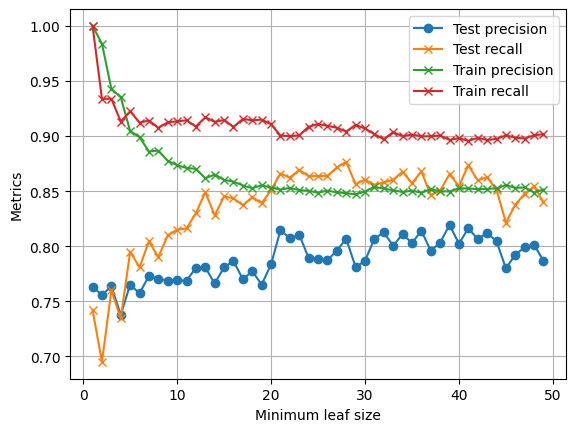

In [7]:
def get_decision_tree_classifier(min_samples_leaf, return_model=True):
    clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)

    cv_results = cross_validate(
        clf, X, y, cv=gss, groups=groups,
        scoring=['precision', 'recall'],
        return_estimator=True,
        return_train_score=True
    )

    print("Mean Precision train:", np.mean(cv_results['train_precision']))
    print("Mean Recall train:", np.mean(cv_results['train_recall']))

    print("Precision for each fold:", cv_results['test_precision'])
    print("Mean Precision:", np.mean(cv_results['test_precision']))

    print("Recall for each fold:", cv_results['test_recall'])
    print("Mean Recall:", np.mean(cv_results['test_recall']))

    best_model_idx = np.argmax(cv_results['test_precision'])
    best_model = cv_results['estimator'][best_model_idx]

    if not return_model:
         return np.mean(cv_results['test_precision']), np.mean(cv_results['test_recall']), np.mean(cv_results['train_precision']), np.mean(cv_results['train_recall'])

    return np.mean(cv_results['test_precision']), np.mean(cv_results['test_recall']), np.mean(cv_results['train_precision']), np.mean(cv_results['train_recall']), best_model



max_val = 50
def avg_decision_tree_classifier(x, runs=10):
    results = [get_decision_tree_classifier(x, return_model=False) for _ in range(runs)]
    avg_result = tuple(sum(values) / runs for values in zip(*results))
    return avg_result

vals = [avg_decision_tree_classifier(x) for x in range(1, max_val)]

y1_vals, y2_vals, y3_vals, y4_vals = zip(*vals)

# Plot both elements of the tuple
plt.plot(range(1, max_val), y1_vals, label='Test precision', marker='o')
plt.plot(range(1, max_val), y2_vals, label='Test recall', marker='x')
plt.plot(range(1, max_val), y3_vals, label='Train precision', marker='x')
plt.plot(range(1, max_val), y4_vals, label='Train recall', marker='x')
plt.xlabel('Minimum leaf size')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
best_model_decision_tree_classifier = get_decision_tree_classifier(20)[4]

plt.figure(figsize=(200, 100))
plot_tree(best_model_decision_tree_classifier, filled=True, feature_names=input_cols, class_names=np.unique(y).astype(str), rounded=True, fontsize=9)
plt.title("Decision Tree of Best Model Based on Precision")
plt.show()

Mean Precision train: 0.8562852574620017
Mean Recall train: 0.900886185821232
Precision for each fold: [0.82845188 0.89380531 0.79901961 0.87042254 0.79901961 0.7027027 ]
Mean Precision: 0.8155702743633243
Recall for each fold: [0.89189189 0.90990991 0.85340314 0.88034188 0.85340314 0.78787879]
Mean Recall: 0.8628047921241638


## Second Tree: Gradient Boosted Decision Tree

Increase precision from average 0.775 to 0,82

In [9]:
from sklearn.ensemble import GradientBoostingClassifier


input_cols_full = ['Answer.duration', 'Answer.confidence', 'Answer.difficulty', 'Answer.option.int', 'Answer.order', 'Worker.score', 'Worker.profession', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender.int', 'TTR']
input_cols = ['Answer.duration', 'Answer.confidence', 'Answer.difficulty', 'Answer.option.int', 'Answer.order', 'Worker.score', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender.int', 'TTR']
output_col = 'correctness'

X_gb = df_train[input_cols]
y_gb = df_train[output_col]

groups = df_train['FailingMethod'].values
gss = GroupShuffleSplit(n_splits=len(pd.unique(groups)), test_size=1/len(pd.unique(groups)))

clf = GradientBoostingClassifier(min_samples_leaf=20)


precision_scores = cross_val_score(clf, X_gb, y_gb, cv=gss, groups=groups, scoring='precision')
recall_scores = cross_val_score(clf, X_gb, y_gb, cv=gss, groups=groups, scoring='recall')

print("Precision for each group split:", precision_scores)
print("Mean Precision:", np.mean(precision_scores))

print("Recall for each group split:", recall_scores)
print("Mean Recall:", np.mean(recall_scores))

Precision for each group split: [0.8313253  0.90723982 0.82142857 0.90723982 0.82142857 0.8313253 ]
Mean Precision: 0.8533312305459718
Recall for each group split: [0.69148936 0.69148936 0.69148936 0.90315315 0.93162393 0.69148936]
Mean Recall: 0.7667890885975993


## Third Tree: Minimal number of input columns
Very high recall but low precision --> many positives (false and true)

In [10]:
from sklearn.ensemble import GradientBoostingClassifier


input_cols_full = ['Answer.duration', 'Answer.confidence', 'Answer.difficulty', 'Answer.option.int', 'Answer.order', 'Worker.score', 'Worker.profession', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender.int', 'TTR']
input_cols_minimal = ['Answer.confidence', 'Answer.difficulty', 'Worker.score', 'Worker.yearsOfExperience']
output_col = 'correctness'

X_gb = df_train[input_cols_minimal]
y_gb = df_train[output_col]

groups = df_train['FailingMethod'].values
gss = GroupShuffleSplit(n_splits=len(pd.unique(groups)), test_size=1/len(pd.unique(groups)))

clf = GradientBoostingClassifier(random_state=42)


precision_scores = cross_val_score(clf, X_gb, y_gb, cv=gss, groups=groups, scoring='precision')
recall_scores = cross_val_score(clf, X_gb, y_gb, cv=gss, groups=groups, scoring='recall')

print("Precision for each group split:", precision_scores)
print("Mean Precision:", np.mean(precision_scores))

print("Recall for each group split:", recall_scores)
print("Mean Recall:", np.mean(recall_scores))


Precision for each group split: [0.67647059 0.58333333 0.76888889 0.76888889 0.76888889 0.76888889]
Mean Precision: 0.7225599128540304
Recall for each group split: [0.98648649 0.98648649 0.96808511 0.96808511 0.98575499 0.94369369]
Mean Recall: 0.9730986441979349


In [11]:
df_train

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,Ground_Truth,TP,TN,FN,...,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness,TTR,Answer.option.int,Worker.gender.int
320,621,HIT03_6,16,225.484,4,2,0.0,0,1,0,...,20.0,35,Male,High School;University,US,c++,1,0.875000,0.0,-1
321,622,HIT03_6,16,75.758,5,2,0.0,0,1,0,...,5.0,26,Male,High School;University,USA,Java,1,0.708333,0.0,-1
322,623,HIT03_6,16,396.716,5,2,0.0,0,0,0,...,10.0,33,Male,University,United States,Java,0,0.576923,1.0,-1
323,624,HIT03_6,16,899.377,4,3,0.0,0,1,0,...,5.0,33,Male,University;Web,USA,matlab; js,1,1.000000,0.0,-1
324,625,HIT03_6,16,253.272,0,5,0.0,0,0,0,...,3.0,49,Female,University,US,php,0,1.000000,0.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2316,HIT08_54,128,220.420,2,4,0.0,0,1,0,...,2.0,28,Male,University,USA,C#,1,0.766667,0.0,-1
2576,2317,HIT08_54,128,322.790,4,3,0.0,0,0,0,...,17.0,39,Male,University;Web,USA,C#; VB.NET; Java,0,0.928571,1.0,-1
2577,2318,HIT08_54,128,159.530,5,1,0.0,0,1,0,...,10.0,31,Male,High School;University;Web;Other work,usa,C++,1,1.000000,0.0,-1
2578,2319,HIT08_54,128,68.578,5,1,0.0,0,1,0,...,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++,1,1.000000,0.0,-1


Adding the workers' professions somehow makes it worse. Maybe I did something wrong here.

In [12]:
df_train['Worker.profession.int'] = df_train['Worker.profession'].map({'Other': 0, 'Hobbyist': 1, 'Undergraduate_Student': 2, 'Graduate_Student': 3, 'Professional_Developer':4})
df_train

/var/folders/f7/k6ksdyss1rdd4kq9f0lc_kl00000gn/T/ipykernel_58821/3285624595.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Worker.profession.int'] = df_train['Worker.profession'].map({'Other': 0, 'Hobbyist': 1, 'Undergraduate_Student': 2, 'Graduate_Student': 3, 'Professional_Developer':4})


,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,Ground_Truth,TP,TN,FN,...,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness,TTR,Answer.option.int,Worker.gender.int,Worker.profession.int
320,621,HIT03_6,16,225.484,4,2,0.0,0,1,0,...,35,Male,High School;University,US,c++,1,0.875000,0.0,-1,0
321,622,HIT03_6,16,75.758,5,2,0.0,0,1,0,...,26,Male,High School;University,USA,Java,1,0.708333,0.0,-1,3
322,623,HIT03_6,16,396.716,5,2,0.0,0,0,0,...,33,Male,University,United States,Java,0,0.576923,1.0,-1,4
323,624,HIT03_6,16,899.377,4,3,0.0,0,1,0,...,33,Male,University;Web,USA,matlab; js,1,1.000000,0.0,-1,1
324,625,HIT03_6,16,253.272,0,5,0.0,0,0,0,...,49,Female,University,US,php,0,1.000000,0.5,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2316,HIT08_54,128,220.420,2,4,0.0,0,1,0,...,28,Male,University,USA,C#,1,0.766667,0.0,-1,3
2576,2317,HIT08_54,128,322.790,4,3,0.0,0,0,0,...,39,Male,University;Web,USA,C#; VB.NET; Java,0,0.928571,1.0,-1,4
2577,2318,HIT08_54,128,159.530,5,1,0.0,0,1,0,...,31,Male,High School;University;Web;Other work,usa,C++,1,1.000000,0.0,-1,4
2578,2319,HIT08_54,128,68.578,5,1,0.0,0,1,0,...,19,Male,University;Web;Other FIRST Robotics,United States,C++,1,1.000000,0.0,-1,2


## Holdout set predicition

In [13]:
groups = df_holdout.groupby('FailingMethod')

precision_per_group = {}
recall_per_group = {}

for method, group in groups:
    X_group = group[input_cols]
    y_group = group[output_col]

    y_pred = best_model_decision_tree_classifier.predict(X_group)

    precision = precision_score(y_group, y_pred)
    recall = recall_score(y_group, y_pred)

    precision_per_group[method] = precision
    recall_per_group[method] = recall

for method in precision_per_group:
    print(f"FailingMethod: {method}")
    print(f"Precision: {precision_per_group[method]}")
    print(f"Recall: {recall_per_group[method]}")
    print("-" * 30)


FailingMethod: HIT01_8
Precision: 0.8082191780821918
Recall: 0.8309859154929577
------------------------------
FailingMethod: HIT02_24
Precision: 0.704225352112676
Recall: 0.7575757575757576
------------------------------


/var/folders/f7/k6ksdyss1rdd4kq9f0lc_kl00000gn/T/ipykernel_58821/1159851008.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bug_rows['Explanation_Size'] = bug_rows['Answer.explanation'].apply(len)


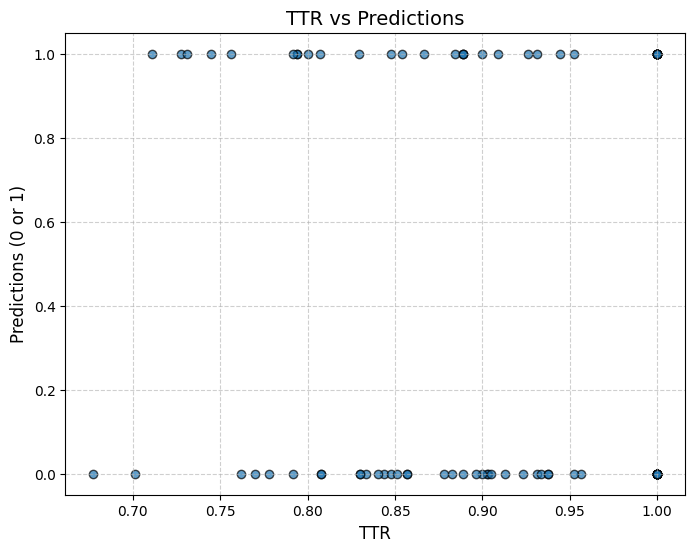

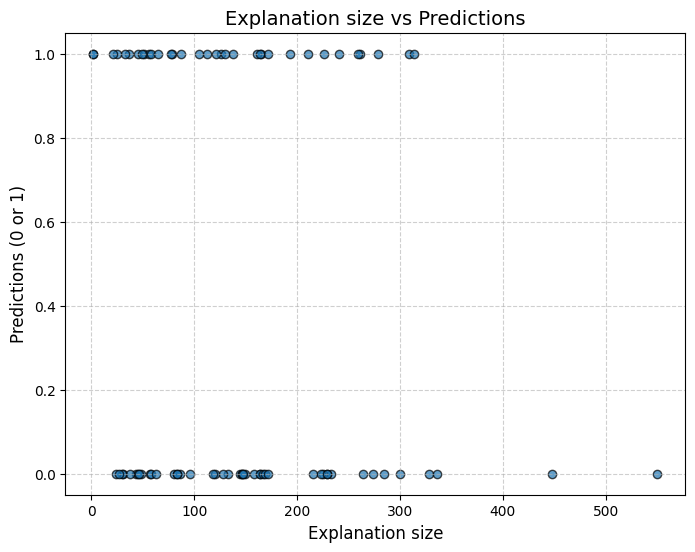

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

bug_rows = df_holdout[df_holdout['GroundTruth'] == 1]

bug_rows['Explanation_Size'] = bug_rows['Answer.explanation'].apply(len)

y_pred = best_model_decision_tree_classifier.predict(bug_rows[input_cols])


plt.figure(figsize=(8, 6))
plt.scatter(bug_rows['TTR'], y_pred, alpha=0.7, edgecolor='k')
plt.title('TTR vs Predictions', fontsize=14)
plt.xlabel('TTR', fontsize=12)
plt.ylabel('Predictions (0 or 1)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(bug_rows['Explanation_Size'], y_pred, alpha=0.7, edgecolor='k')
plt.title('Explanation size vs Predictions', fontsize=14)
plt.xlabel('Explanation size', fontsize=12)
plt.ylabel('Predictions (0 or 1)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [15]:
df_holdout[df_holdout['TP'] == 1 ]


,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,Ground_Truth,TP,TN,FN,...,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness,TTR,Answer.option.int,Worker.gender.int
20,441,HIT01_8,1,140.407,4,3,1.0,1,0,0,...,3.0,49,Female,University,US,php,1,1.000000,1.0,1
22,443,HIT01_8,1,112.409,5,2,1.0,1,0,0,...,5.0,20,Male,University;Web,USA,c#,1,0.931034,1.0,-1
23,444,HIT01_8,1,76.418,5,1,1.0,1,0,0,...,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++,1,0.903226,1.0,-1
24,445,HIT01_8,1,261.928,5,2,1.0,1,0,0,...,1.0,25,Female,University,USA,java,1,0.770000,1.0,1
25,446,HIT01_8,1,236.045,5,1,1.0,1,0,0,...,5.0,29,Male,University;Other On the job,USA,Python; SQL; Java,1,0.882353,1.0,-1
27,448,HIT01_8,1,259.790,3,3,1.0,1,0,0,...,1.0,30,Female,University,united states,none,1,0.902439,1.0,1
28,449,HIT01_8,1,230.142,4,3,1.0,1,0,0,...,4.0,35,Male,High School,USA,php and C++,1,0.830189,1.0,-1
29,450,HIT01_8,1,253.302,4,2,1.0,1,0,0,...,4.0,35,Male,University;Web;Other MOOC,USA,Java Python,1,0.761905,1.0,-1
30,451,HIT01_8,1,89.521,4,3,1.0,1,0,0,...,14.0,34,Male,High School;University;Web;Other books,Russia,C++;Object Pascal,1,0.937500,1.0,-1
34,455,HIT01_8,1,161.419,4,4,1.0,1,0,0,...,2.0,24,Male,University,India,c; c++,1,0.807692,1.0,-1


In [21]:
from openai import OpenAI

question_groups = df_holdout[df_holdout['TP'] == 1 ].groupby(['FailingMethod', 'Question.ID'])
client = OpenAI(
    api_key=""
)

explanations_list = []

for m, group in question_groups:
    explanations = group['Answer.explanation'].to_list()
    explanations_list.append(explanations)
    print('Number of explanations', len(group['Answer.explanation']))


print('Number of groups', len(question_groups))


Number of explanations 12
Number of explanations 15
Number of explanations 4
Number of explanations 9
Number of explanations 9
Number of groups 5


In [22]:
def get_prompt_1(explanations):
        return f"""
I give you the following task, after that the relevant data. You have to solve the task with the data (filtered explanations) I give you, each separate explanation is separated by a newline character

for the correct answers to the inspection tasks hosting the bug, prompt the LLM
to generate a single explanation by merging the participants’ explanations in a way that minimizes
redundant information, while keeping the information that would be necessary for someone else to fix the
bug.
• Types of information that, if present in the explanation, should be preserved - how the program works,
how the failure is happening, what is problem in the code, etc.

{explanations}

"""

def get_prompt_2(explanations):
        return f"""
Please summarize these reports of the same bug. Remove redundant information, but make sure that every information given in the explanations is retained that would be needed to fix the bug. Summarize the report of the bug concisely. Keep the summary as short as possible.

These the reports:

{explanations}

"""

In [23]:
for explanations in explanations_list:
    print(get_prompt_2(str(explanations)))


Please summarize these reports of the same bug. Remove redundant information, but make sure that every information given in the explanations is retained that would be needed to fix the bug. Summarize the report of the bug concisely. Keep the summary as short as possible.

These the reports:

['Minutes are set to -15; which is less then 0 and it throws illegal arg exception', 'In the code there is a check that 0 <= minutes < 60 and the minutesOffset is -15 which does not fall into these prarmeters thus throwing an Exception', 'There is a logical check for if minuteOffset is less than 0 or greater than 59 causing it to throw an exception because the value is out of bounds (negative number)', 'YES. The issue is on line 279 (as I explained in my first question; of which I misunderstood that I was only being asked about the specific issue; not generalized issue). On line 279 the variable "minutesOffSet" is parameterized to throw an exception if it is < 0 or > 59. Line 279 should read "if (

In [26]:
from tqdm import tqdm


def get_results(get_prompt_function):

    results = []

    for explanations in tqdm(explanations_list):

        chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": get_prompt_function(str(explanations)),
            }
        ],
        model="gpt-4o-mini",
    )

        results.append(chat_completion.choices[0].message.content)

    results_df = pd.DataFrame(results, columns=['text']).reset_index()

    results_df['complexity'] = results_df['text'].astype(str).apply(calculate_ttr)
    results_df['length'] = results_df['text'].astype(str).apply(len)

    return results_df

In [27]:
from IPython.core.display import Markdown

prompt_1_results = get_results(get_prompt_1)
prompt_2_results = get_results(get_prompt_2)

display(prompt_1_results)
display(prompt_2_results)


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


,index,text,complexity,length
0,0,The bug is occurring due to the handling of th...,0.592965,1297
1,1,The bug occurs in a method where the input for...,0.550000,1368
2,2,The program experiences an issue related to th...,0.719626,653
3,3,The main issue in the program arises when tryi...,0.646409,1083
4,4,The issue with the bug arises primarily from t...,0.656805,1091


,index,text,complexity,length
0,0,**Bug Summary:**\n\nThe variable `minutesOffse...,0.852941,474
1,1,**Bug Summary:**\n\nThe condition on line 279 ...,0.846154,515
2,2,"The bug is related to line 279, where the vari...",0.708861,441
3,3,"The reports indicate that the variable ""g"" mus...",0.693878,602
4,4,**Bug Summary:**\n\nThe exception arises from ...,0.722892,522


In [34]:
for index, result in enumerate(prompt_2_results['text']):
    display(Markdown(f'## Result for Text {index + 1}'))
    display(Markdown(result))

## Result for Text 1

**Bug Summary:**

The variable `minutesOffset` is incorrectly validated on line 279 of the code. It currently checks if `minutesOffset < 0`, leading to an `IllegalArgumentException` when the value is -15 (set by `DateTimeZone.forOffsetHoursMinutes(-2, -15)`). The correct check should be `if (minutesOffset < -59 || minutesOffset > 59)`, as valid input for `minutesOffset` should range from -59 to +59. This validation error prevents the method from being invoked correctly.

## Result for Text 2

**Bug Summary:**

The condition on line 279 incorrectly throws an IllegalArgumentException when the `minutesOffset` is negative (e.g., -15), as it currently checks if `minutesOffset < 0` instead of allowing negative minutes if the hour offset is also negative. According to comments, valid minute values should be between -59 and +59, but the current implementation only validates for non-negative values (0 to 59). Therefore, a revision is needed to properly handle cases where both hours and minutes are negative.

## Result for Text 3

The bug is related to line 279, where the variable "minutesOffSet" is incorrectly set to throw an exception if it is less than 0, but it should instead throw an exception for values less than -59. Additionally, there may be issues with the parameters passed, which could lead to "millis out of range," and the offset variable is still zero, causing it to be out of range. Line 284 also references an error with the offset described in hours.

## Result for Text 4

The reports indicate that the variable "g" must be within the range of 0-255, but it is being assigned a value of -0.5, leading to invalid Color object values. The parameters for the color constructor should be between 0.0 and 1.0, and the argument "value" is incorrectly used instead of "v" on line 117, allowing it to exceed the defined lowerBound and upperBound. There is no validation to ensure that the lower range is positive, resulting in unhandled negative values. The resulting variable "v" is not properly utilized, causing the negative value to persist and throw an IllegalArgumentException.

## Result for Text 5

**Bug Summary:**

The exception arises from the Color constructor due to an invalid value for the variable "g". It appears that "g" can be computed as a negative integer when a negative parameter is passed, leading to an illegal argument exception. The definitions of `this.lowerBound` and `this.upperBound` are necessary for further diagnosis. Additionally, "g" should be a float and needs to be calculated using "v" instead of "value". There is a possibility that "g" is outside the acceptable range for the Color class.

In [35]:
import nltk
from rouge import Rouge

def calculate_bleu(hyp, ref):
    hypothesis = hyp.split()
    reference = ref.split()
    return nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)

rouge = Rouge()
def calculate_rouge(hyp, ref):
    scores = rouge.get_scores(hyp, ref)
    return scores[0]['rouge-1']['f']

In [37]:
explanation_indices = []
hyp_texts = []
ref_texts = []
bleu_vals = []
rouge_vals = []

for index, explanations in enumerate(explanations_list):
    hyp = prompt_2_results.iloc[index]['text']


    for ref in explanations:
        if len(ref.split(' ')) < 5:
            continue
        explanation_indices.append(index)
        hyp_texts.append(hyp)
        ref_texts.append(ref)
        bleu_vals.append(calculate_bleu(hyp, ref))
        rouge_vals.append(calculate_rouge(hyp, ref))

data = {
    'Explanation index': explanation_indices,
    'Hyp text': hyp_texts,
    'Ref text': ref_texts,
    'bleu': bleu_vals,
    'rouge': rouge_vals,
}


similarity_metrics = pd.DataFrame(data)

similarity_metrics


/Users/lucas/PycharmProjects/ASE-GenAI/venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/lucas/PycharmProjects/ASE-GenAI/venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/lucas/PycharmProjects/ASE-GenAI/venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower o

,Explanation index,Hyp text,Ref text,bleu,rouge
0,0,**Bug Summary:**\n\nThe variable `minutesOffse...,Minutes are set to -15; which is less then 0 a...,7.544641e-232,0.053333
1,0,**Bug Summary:**\n\nThe variable `minutesOffse...,In the code there is a check that 0 <= minutes...,3.144756e-155,0.186047
2,0,**Bug Summary:**\n\nThe variable `minutesOffse...,There is a logical check for if minuteOffset i...,1.102965e-78,0.206897
3,0,**Bug Summary:**\n\nThe variable `minutesOffse...,YES. The issue is on line 279 (as I explained ...,7.021090e-02,0.308824
4,0,**Bug Summary:**\n\nThe variable `minutesOffse...,"The variable ""minutesOffset"" is checked incorr...",4.018640e-155,0.269663
5,0,**Bug Summary:**\n\nThe variable `minutesOffse...,This variable contains a value of -15 as set b...,1.288230e-231,0.329897
6,0,**Bug Summary:**\n\nThe variable `minutesOffse...,Yes; the variable gets set to -15 through the ...,1.433088e-78,0.352941
7,0,**Bug Summary:**\n\nThe variable `minutesOffse...,As noted in the comments; valid input for minu...,9.378377e-02,0.317757
8,0,**Bug Summary:**\n\nThe variable `minutesOffse...,"the variable should be defined as ""unsigned in...",2.953254e-155,0.189189
9,0,**Bug Summary:**\n\nThe variable `minutesOffse...,The value of minutes offset does not have vali...,1.031943e-231,0.175000
